In [1]:
import os
import math
import time
import pickle
import json
import spacy
import requests
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from time import sleep
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from selenium import webdriver
from scrapy.selector import Selector

from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE, SVMSMOTE
from sklearn.metrics import accuracy_score, classification_report, roc_curve, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix

plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
def save_file(obj, name) :
    '''
        Function to save data as pickle file
    '''
    with open('data/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f)

def load_file(name):
    '''
        Function to load data from pickle file
    '''
    with open('data/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [3]:
search_terms = ['data scientist', 'data analyst', 'data engineer', 'data architect', 'machine learning', 'business analyst', 'business intelligence',
               'data visualisation', 'data consultant', 'deep learning', 'big data', 'data analytics', 'business analytics', 'data science']

In [4]:
def get_job_from_api(search_term, jobs_per_page=50):
    '''
        Function to retrieve jobs from the mycareersfuture api
    '''
    num_jobs = 0
    url = f"https://api.mycareersfuture.sg/jobs?search={search_term}&limit={jobs_per_page}&page=0&sortBy=new_posting_date"
    response = requests.get(url)
    if (response.status_code == 200):
        jobs = json.loads(response.text)
        num_jobs = jobs['count']
    
    jobs_data = []
    if (num_jobs > 0):
        for page in range(math.ceil(num_jobs/jobs_per_page)):
            url = f"https://api.mycareersfuture.sg/jobs?search={search_term}&limit={jobs_per_page}&page={page}&sortBy=new_posting_date"
            response = requests.get(url)
            if (response.status_code == 200):
                jobs = json.loads(response.text)
                jobs_data.extend(jobs['jobs'])
    
    return jobs_data

In [5]:
## Run this cell to retrieve the job data from the api and save to file

# job_data_file = load_file('job_data')
# for job in search_terms:
#     job_data = get_job_from_api(job)
#     job_data_file.extend(job_data)

# temp_job_df = pd.DataFrame(job_data_file)
# temp_job_df.drop_duplicates('uuid', inplace=True)
# save_file(temp_job_df.to_dict('records'), 'job_data')

In [6]:
# load data
jobs = pd.DataFrame(load_file('job_data'))

**Initial cleaning**

From the job titles below, we can see that some of the jobs retrieved are not data-related and some jobs are posted multiple times as well. Let's clean this up a little before scraping more details for each job.

In [7]:
jobs['job_title'].value_counts()

Business Analyst                                                                              87
Data Scientist                                                                                57
Research Fellow                                                                               34
Data Engineer                                                                                 30
Data Engineer (5 days, Orchard, $3500-4000)                                                   23
Senior Business Analyst                                                                       21
Research Associate                                                                            17
Data Analyst                                                                                  17
Key Account Manager ($3500 – 5500, 5 Days, River Valley)                                      16
Manager                                                                                       13
Business System Analyst       

There are some fields in the data that might be useful in filtering out the data-related jobs. I am going to use the `job_title_score` and `job_description_score` (which I think are scores to indicate how relevant the job title and description are with reference to the search term).

In [8]:
# filter jobs that have job_title_score equals 1 or job_description_score >= 1
jobs = jobs[(jobs['job_title_score'] == 1) | (jobs['job_description_score'] >= 1)]

In [9]:
# results after filtering
jobs['job_title'].value_counts()

Business Analyst                                                                                        87
Data Scientist                                                                                          57
Research Fellow                                                                                         33
Data Engineer                                                                                           27
Data Engineer (5 days, Orchard, $3500-4000)                                                             23
Senior Business Analyst                                                                                 21
Research Associate                                                                                      17
Data Analyst                                                                                            17
Key Account Manager ($3500 – 5500, 5 Days, River Valley)                                                16
Manager                              

In [10]:
def remove_duplicate_job_posts(job_title, remove_all=False):
    index = jobs[jobs['job_title'] == job_title].index
    if (remove_all):
        jobs.drop(index, inplace=True)        
    else:
        jobs.drop(index[1:], inplace=True)

In [11]:
# remove duplicate job posts
duplicate_jobs = ['Data Engineer (5 days, Orchard, $3500-4000)', 'Senior Database Consultant - Big Data Engineer',
                  'Scientist (Deep Learning 2.0), I2R/A*STAR']
for job in duplicate_jobs:
    remove_duplicate_job_posts(job)

In [12]:
# remove non-data related jobs
non_data_jobs = ['Key Account Manager ($3500 – 5500, 5 Days, River Valley)', 'Manager', 'Project Officer', 'Software Engineer', 'Senior Software Engineer',
                'Application Developer', 'Project Manager', 'Appplication Developer', 'Chief Financial Officer', 'VP, Sales', 'MANAGERIAL/SENIOR MANAGEMENT',
                'Director of Sales Engineering, APJ', 'FPGA Application Developer (AI Platform)', 'Senior Technology Specialist',
                 'Digital Marketing Manager - APJ','Regional Sales Operations Lead, APAC', 'PRODUCT MANAGER (DEX)',
                'Channel Partner Recruitment Manager', 'APJ Media Manager', 'Product Designer', 'APJ Media Manager',
                'Project Manager, Systems Integration (3-year contract), Centre for Teaching Excellence',
                'Internship with Sport Singapore', 'Scrum Master', 'Human Resource & Administrative Officer',
                'Logistic and Procurement Executive', 'recuritment consultant manager', 'Case Manager',
                'Sales Development Representative (Japanese)', 'Sales Development Representative (Korean)',
                'Full Stack Developer', 'Software Developer', 'Scrum Master - Cybersecurity', 'Delivery Manager',
                'Human Resource Executive', 'Key Account Manager - IT solutions ($3500 – 5500, 5 Days, River Valley)',
                'Senior Manager', 'Research Fellow', 'Research Associate', 'Research Assistant',
                'Research Fellow (1-year contract),\xa0 Living Analytics Research Centre', 'HR Practitioner'
                'Research Scientist (1-year contract),\xa0  Living Analytics Research Centre', 
                 'Senior Research Fellow', 'Java Robotics Developer']
for job in non_data_jobs:
    remove_duplicate_job_posts(job, remove_all=True)

**Retrieve more details for each job using another api**

In [13]:
def get_job_details_from_api(uuid):
    url = f"https://api.mycareersfuture.sg/v2/jobs/{uuid}"
    response = requests.get(url)
    if (response.status_code == 200):
        return json.loads(response.text)
    else:
        print (f"{uuid} with status code: {response.status_code}")

In [14]:
## Run this cell to retrieve the job details from the api and save to file

# job_details_list = []
# for i, uuid in enumerate(jobs['uuid']):
#     details = get_job_details_from_api(uuid)
#     job_details_list.append(details)
#     if (i%50 == 49):
#         sleep(1)
#     if (i%200 == 199):
#         print (f"-------Retrieved {i+1} entries-------")
# save_file(job_details_list, 'job_details_list')

In [15]:
# load job details file
job_details = pd.DataFrame(load_file('job_details_list'))

In [16]:
job_details.columns

Index(['_links', 'address', 'applicationUrl', 'categories', 'description',
       'employmentTypes', 'hiringCompany', 'metadata',
       'minimumYearsExperience', 'numberOfVacancies', 'otherRequirements',
       'positionLevels', 'postedCompany', 'psdUrl', 'salary', 'schemes',
       'shiftPattern', 'skills', 'sourceCode', 'ssocCode', 'status', 'title',
       'uuid', 'workingHours'],
      dtype='object')

Nothing interesting in the `workingHours` column.

In [17]:
job_details['workingHours'].unique()

array([None], dtype=object)

Going to keep the job details that are useful and merge it into the `jobs` dataframe.

> I chose not to keep the skills column because I realised that the skills, which are proposed by a skills recommender system (JobKred), do not really match the requirements of the job. For example, a data scientist role at a bank which required skills such as Spark, SQL, Python etc was not tagged with these skills. Instead,
skills such as Financial Reporting and Mergers & Acquisitions were tagged.

In [18]:
relevant_job_details = ['uuid', 'otherRequirements']

In [19]:
job_details = job_details[relevant_job_details]
job_details.head()

,uuid,otherRequirements
0,8adb5c22263d490fd19ff2b6362b9be4,<ul> \t<li> \t<p>Solid programming skills and ...
1,cee58da0b16561b6d739767873dc8bd1,<ul> \t<li> \t<p>Solid programming skills and ...
2,8dba1deab655a0a840105310f2308dc2,<ul> \t<li> \t<p>Solid programming skills and ...
3,1cd7eaa9c04792e882aad755fce1d921,<ul> \t<li> \t<p>Solid programming skills and ...
4,3e44f41193fa546b0269a694af5bdf16,<ul> <li>Degree in a quantitative subject (e...


**Merge the two dataframes**

In [20]:
jobs_before_cleaning = jobs.merge(job_details, on='uuid')
jobs_before_cleaning.head()

,categories,company_description,company_name_score,created_on,district_ids,employer_name,employment_types,exact_company_score,exact_string_score,expiry_date,...,original_posting_date,position_levels,presumed_salary,salary_type,schemes,skills,total_number_job_application,total_number_of_view,uuid,otherRequirements
0,[Information Technology],<p>Traveloka is a technology company based in ...,0,2019-04-24T16:00:00.000Z,[2],TRAVELOKA SERVICES PTE. LTD.,[Permanent],0,1,2019-05-24T16:00:00.000Z,...,2019-04-24T16:00:00.000Z,[Executive],15000,Monthly,[CSP],"[{'id': 8523, 'skill': 'SQL'}, {'id': 8355, 's...",0,4,8adb5c22263d490fd19ff2b6362b9be4,<ul> \t<li> \t<p>Solid programming skills and ...
1,[Information Technology],<p>Traveloka is a technology company based in ...,0,2019-04-24T16:00:00.000Z,[2],TRAVELOKA SERVICES PTE. LTD.,[Permanent],0,1,2019-05-24T16:00:00.000Z,...,2019-04-24T16:00:00.000Z,[Executive],10700,Monthly,[CSP],"[{'id': 8523, 'skill': 'SQL'}, {'id': 8355, 's...",0,2,cee58da0b16561b6d739767873dc8bd1,<ul> \t<li> \t<p>Solid programming skills and ...
2,[Information Technology],<p>Traveloka is a technology company based in ...,0,2019-04-24T16:00:00.000Z,[2],TRAVELOKA SERVICES PTE. LTD.,[Permanent],0,1,2019-05-24T16:00:00.000Z,...,2019-04-24T16:00:00.000Z,[Executive],7600,Monthly,[CSP],"[{'id': 8523, 'skill': 'SQL'}, {'id': 8355, 's...",0,0,8dba1deab655a0a840105310f2308dc2,<ul> \t<li> \t<p>Solid programming skills and ...
3,[Information Technology],<p>Traveloka is a technology company based in ...,0,2019-04-24T16:00:00.000Z,[2],TRAVELOKA SERVICES PTE. LTD.,[Permanent],0,1,2019-05-24T16:00:00.000Z,...,2019-04-24T16:00:00.000Z,[Fresh/entry level],6000,Monthly,[CSP],"[{'id': 8523, 'skill': 'SQL'}, {'id': 8355, 's...",0,1,1cd7eaa9c04792e882aad755fce1d921,<ul> \t<li> \t<p>Solid programming skills and ...
4,[Banking and Finance],<p>\r\n\tThe OCBC Bank group of businesses com...,0,2019-04-24T16:00:00.000Z,[1],OVERSEA-CHINESE BANKING CORPORATION LIMITED,[Permanent],0,1,2019-05-24T16:00:00.000Z,...,2019-04-24T16:00:00.000Z,[Professional],8000,Monthly,[CSP],"[{'id': 2239, 'skill': 'Data Management'}, {'i...",0,5,3e44f41193fa546b0269a694af5bdf16,<ul> <li>Degree in a quantitative subject (e...


<h2> Data cleaning </h2>

**Drop rows which do not have salary**

There is a small proportion of the data that does not have salary information. I am dropping these rows because the salary information is needed as the target variable later.

In [21]:
jobs = jobs_before_cleaning[(~jobs_before_cleaning['max_monthly_salary'].isnull()) & (~jobs_before_cleaning['min_monthly_salary'].isnull())]

In [22]:
jobs.shape

(1246, 40)

**Keep relevant columns**

In [23]:
jobs.columns

Index(['categories', 'company_description', 'company_name_score', 'created_on',
       'district_ids', 'employer_name', 'employment_types',
       'exact_company_score', 'exact_string_score', 'expiry_date',
       'hidden_name', 'hiring_employer_name', 'is_hide_employer_name',
       'is_hide_hiring_employer_name', 'is_hide_salary', 'is_posted_on_behalf',
       'job_description', 'job_description_score', 'job_post_id', 'job_title',
       'job_title_score', 'logo_file_name', 'logo_upload_path', 'logo_url',
       'matched_skills_score', 'max_monthly_salary', 'min_monthly_salary',
       'min_years_experience', 'modified_on', 'new_posting_date',
       'original_posting_date', 'position_levels', 'presumed_salary',
       'salary_type', 'schemes', 'skills', 'total_number_job_application',
       'total_number_of_view', 'uuid', 'otherRequirements'],
      dtype='object')

In [24]:
relevant_columns = ['uuid', 'employer_name', 'employment_types',
       'job_description', 'job_title', 'max_monthly_salary', 'min_monthly_salary', 'salary_type',
       'min_years_experience', 'position_levels', 'otherRequirements', 'categories', 'district_ids']

In [25]:
jobs = jobs[relevant_columns]

**Data dictionary**

* **uuid**: unique id for job post (string)
* **employer_name**: name of employer (string)
* **employment_types**: list of employment types eg. permanent, contract (list of strings)
* **job_description**: description of job (string)
* **job_title**: job title (string)
* **max_monthly_salary**: maximum value of the monthly salary range (float)
* **min_monthly_salary**: minimum value of the monthly salary range (float)
* **salary_type**: either monthly or annually (string)
* **min_years_experience**: minimum number of years of experience (float)
* **position_levels**: list of position levels for the job eg. executive, senior management (list of strings)
* **otherRequirements**: skills / requirements of the job (string)
* **categories**: list of industry type (list of strings)
* **district_ids**: list of singapore district ids that the company operates in (list of int)

In [26]:
jobs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1246 entries, 0 to 1334
Data columns (total 13 columns):
uuid                    1246 non-null object
employer_name           1128 non-null object
employment_types        1246 non-null object
job_description         1246 non-null object
job_title               1246 non-null object
max_monthly_salary      1246 non-null float64
min_monthly_salary      1246 non-null float64
salary_type             1246 non-null object
min_years_experience    119 non-null float64
position_levels         1214 non-null object
otherRequirements       1164 non-null object
categories              1246 non-null object
district_ids            1163 non-null object
dtypes: float64(3), object(10)
memory usage: 136.3+ KB


**Actions to take:**

* `employer_name`: Fill in null values with 'NA'
* `min_years_experience`: Not very useful because it contains more than 90% `None` values. Drop column.
* `position_levels`: Fill in null values with most common position level.
* `otherRequirements`: Fill in null values with 'NA'
* `district_ids`: Check if there is district in `address` and try to fill in.

**Fill in missing employer name**

In [27]:
jobs.loc[jobs['employer_name'].isnull(), 'employer_name'] = 'NA'

**Drop `min_years_experience` because it has more than 90% `None` values**

In [28]:
jobs.drop('min_years_experience', axis=1, inplace=True)

**Fill in missing position levels**

Fill in the missing position level with 'Professional' which is the most common value

In [29]:
jobs['position_levels'] = [value[0] if value != None else 'Professional' for value in jobs['position_levels']]

In [30]:
jobs['position_levels'].value_counts()

Professional         405
Executive            253
Manager              141
Senior Executive     135
Middle Management    114
Senior Management     72
Fresh/entry level     47
Junior Executive      42
Non-executive         37
Name: position_levels, dtype: int64

**Fill in missing requirements**

In [31]:
jobs.loc[jobs['otherRequirements'].isnull(), 'otherRequirements'] = 'NA'

**Create dummy variables for district values**

In [32]:
def unique_district_ids(district_ids):
    '''
        Function to find the set of unique district ids
    '''
    all_ids = []
    for district_id in district_ids:
        if (district_id):
            all_ids.extend(district_id)
    return set(all_ids)

In [33]:
unique_districts = unique_district_ids(jobs['district_ids'])

In [34]:
# initialize the dummy variable columns for each district id
for district_id in unique_districts:
    jobs[f"district_{district_id}"] = np.zeros(jobs.shape[0])

In [35]:
# each district id in singapore maps to a region
region_district_map = {
    'north': [19, 20, 25, 26, 27, 28],
    'south': [3, 4, 5],
    'east': [6, 7, 14, 15, 16, 17, 18],
    'west': [21, 22, 23, 24],
    'central': [1, 2, 8, 9, 10, 11, 12, 13],
    'islandwide': [9999]
}

In [36]:
# initialize the dummy variable columns for each region
for key in region_district_map.keys():
    jobs[key] = np.zeros(jobs.shape[0])

In [37]:
def find_region_from_district(district_id):
    '''
        Function to find the corresponding region from the district id
    '''
    for region, ids in region_district_map.items():
        if district_id in ids:
            return region

In [38]:
def fill_districts(row):
    '''
        Function to fill in the dummy variable columns created
    '''
    ids = row['district_ids']
    if (ids): # if district ids are present in the district_ids column
        for district in ids:
            row[f"district_{district}"] = 1 # fill in the district id dummy variable
            row[find_region_from_district(district)] = 1 # fill in the region dummy variable

    return row   

In [39]:
jobs = jobs.apply(fill_districts, axis=1)
jobs.drop(['district_ids'], axis=1, inplace=True)

In [40]:
jobs.head()

,uuid,employer_name,employment_types,job_description,job_title,max_monthly_salary,min_monthly_salary,salary_type,position_levels,otherRequirements,...,district_25,district_26,district_27,district_28,north,south,east,west,central,islandwide
0,8adb5c22263d490fd19ff2b6362b9be4,TRAVELOKA SERVICES PTE. LTD.,[Permanent],<p>Job Description</p> <p>As a Data scientist...,Senior Level Data Scientist,15000.0,8300.0,Monthly,Executive,<ul> \t<li> \t<p>Solid programming skills and ...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,cee58da0b16561b6d739767873dc8bd1,TRAVELOKA SERVICES PTE. LTD.,[Permanent],"<p>As a Data scientist, you will be applying m...",Mid - Senior Level Data Scientist,10700.0,6100.0,Monthly,Executive,<ul> \t<li> \t<p>Solid programming skills and ...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,8dba1deab655a0a840105310f2308dc2,TRAVELOKA SERVICES PTE. LTD.,[Permanent],"<p>As a Data scientist, you will be applying m...",Mid Level Data Scientist,7600.0,4300.0,Monthly,Executive,<ul> \t<li> \t<p>Solid programming skills and ...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1cd7eaa9c04792e882aad755fce1d921,TRAVELOKA SERVICES PTE. LTD.,[Permanent],"<p>As a Data scientist, you will be applying m...",Junior - Mid Level Data Scientist,6000.0,3000.0,Monthly,Fresh/entry level,<ul> \t<li> \t<p>Solid programming skills and ...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,3e44f41193fa546b0269a694af5bdf16,OVERSEA-CHINESE BANKING CORPORATION LIMITED,[Permanent],<ul> <li>Develop data science solutions to s...,Data Scientist,8000.0,4800.0,Monthly,Professional,<ul> <li>Degree in a quantitative subject (e...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


**Convert annual salary to monthly salary**

This is to ensure fair comparison among the jobs.

In [41]:
jobs['salary_type'].unique()

array(['Monthly', 'Annually'], dtype=object)

In [42]:
jobs.loc[jobs['salary_type'] == 'Annually', ['max_monthly_salary', 'min_monthly_salary']] = \
    jobs[jobs['salary_type'] == 'Annually'][['max_monthly_salary', 'min_monthly_salary']]/12

In [43]:
jobs.drop('salary_type', axis=1, inplace=True)

**Create dummy variables for industry type**

In [44]:
# Find the set of unique industry types
job_categories = []
for cat in jobs['categories']:
    job_categories.extend(cat)

In [45]:
np.unique(job_categories)

array(['Accounting / Auditing / Taxation', 'Admin / Secretarial',
       'Advertising / Media ', 'Architecture / Interior Design',
       'Banking and Finance', 'Building and Construction', 'Consulting ',
       'Customer Service', 'Design', 'Education and Training',
       'Engineering', 'Environment / Health  ', 'Events / Promotions ',
       'F&B', 'General Management', 'General Work',
       'Healthcare / Pharmaceutical', 'Human Resources ',
       'Information Technology', 'Insurance', 'Legal',
       'Logistics / Supply Chain', 'Manufacturing',
       'Marketing / Public Relations ', 'Others', 'Professional Services',
       'Public / Civil Service', 'Purchasing / Merchandising',
       'Real Estate / Property Management', 'Risk Management',
       'Sales / Retail ', 'Sciences / Laboratory / R&D',
       'Social Services', 'Telecommunications', 'Travel / Tourism'],
      dtype='<U33')

In [46]:
# Initialize dummy variable columns for industry types
for cat in np.unique(job_categories):
    jobs[cat] = np.zeros(jobs.shape[0])

In [47]:
def fill_industries(row):
    for cat in row['categories']:
        row[cat] = 1
    return row

In [48]:
jobs = jobs.apply(fill_industries, axis=1)
jobs.drop('categories', axis=1, inplace=True)

**Cleaning employment types**

In [49]:
employment_type = []
for employment in jobs['employment_types']:
    if len(employment) == 1:
        employment_type.append(employment[0])
    else:
        if "Permanent" in employment:
            employment_type.append("Permanent")
        elif "Internship" in employment:
            employment_type.append("Internship")
        elif "Contract" in employment:
            employment_type.append("Contract")
        elif "Full Time" in employment:
            employment_type.append("Full Time")

In [50]:
jobs['employment_types'] = employment_type

In [51]:
jobs['employment_types'].value_counts()

Permanent     561
Full Time     433
Contract      242
Internship      6
Temporary       4
Name: employment_types, dtype: int64

**Cleaning text features**

In [52]:
# python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")

In [53]:
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

In [54]:
def clean_text(text):
    text = strip_html_tags(text) # strip out html tags
    text = text.lower() # change to lower case
    text = nlp(text) # process text to get lemma
    
    # -PRON- is spacy's custom pronoun lemma. Keep the original word if it is a pronoun.
    # Keep the word 'data' instead of converting to 'datum'
    return ' '.join([word.lemma_ if word.lemma_ not in ['-PRON-', 'datum'] else word.text for word in text]) 

In [55]:
jobs['job_description'] = jobs['job_description'].map(clean_text)

In [56]:
jobs['otherRequirements'] = jobs['otherRequirements'].map(clean_text)

<h2> Question 1 - Factors that impact salary </h2>

<h3> EDA </h3>

**Distribution of salary**

In [57]:
jobs[['min_monthly_salary', 'max_monthly_salary']].describe()

,min_monthly_salary,max_monthly_salary
count,1246.000000,1246.000000
mean,5511.676833,8888.277421
std,2591.419102,4581.707979
min,0.000000,0.000000
25%,4000.000000,6000.000000
50%,5000.000000,8000.000000
75%,7000.000000,11000.000000
max,17000.000000,70000.000000


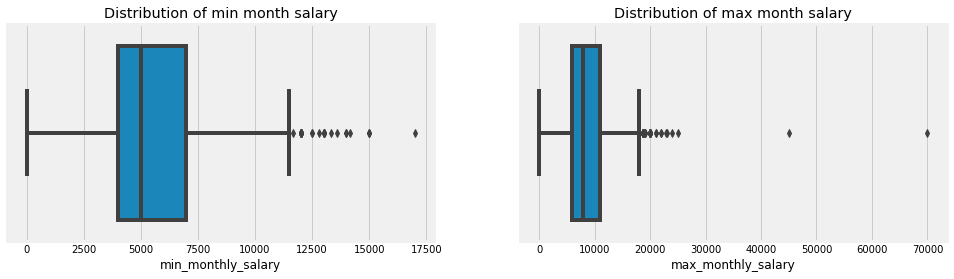

In [58]:
plt.figure(figsize=(15,4))
plt.subplot(121)
sns.boxplot(jobs['min_monthly_salary'])
plt.title('Distribution of min month salary')
plt.subplot(122)
sns.boxplot(jobs['max_monthly_salary'])
plt.title('Distribution of max month salary')
plt.show()

There are 2 extreme outliers in the `max_monthly_salaries`. Hence, as a conservative estimate for the job salary, I will be taking the median `min_monthly_salary` as the threshold to determine whether the salary is low or high. Taking the median salary would also create an equal class distribution between the low and high salary classes.

In [59]:
# create target variable is_high_salary
jobs['is_high_salary'] = [1 if value > jobs['min_monthly_salary'].median() else 0 for value in jobs['min_monthly_salary']]

**Distribution of employment type in each class**

From the distribution in each class, we can see that high salary jobs have 3 times as many permanent positions as compared to contract positions. However, for low salary jobs, there are less than 2 times as many permanent positions as compared to contract positions. Employment type might be a good predictor of each class.

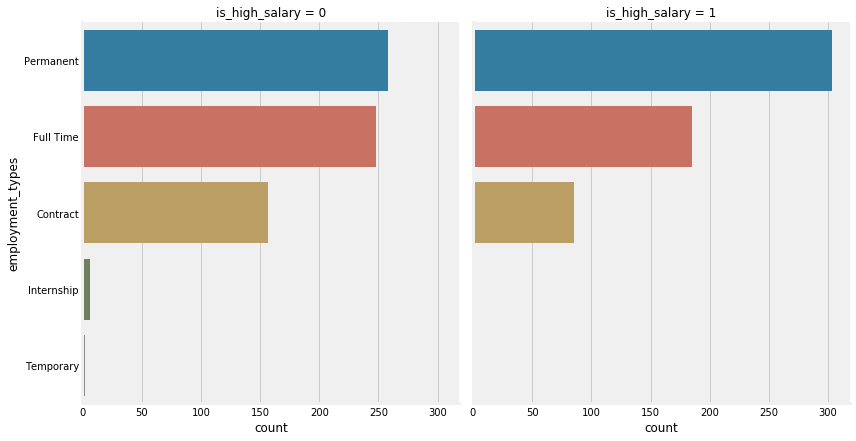

In [60]:
g = sns.catplot(y="employment_types", col="is_high_salary",
                data=jobs, saturation=.5,
                kind="count", ci=None, aspect=1, height=6, orient="h")
plt.show()

**Distribution of position level in each class**

From the plots, we can see that high salary jobs have more manager and senior management positions and fewer executive, entry level, non-executive and junior executive positions. Both classes have a high number of professional positions.

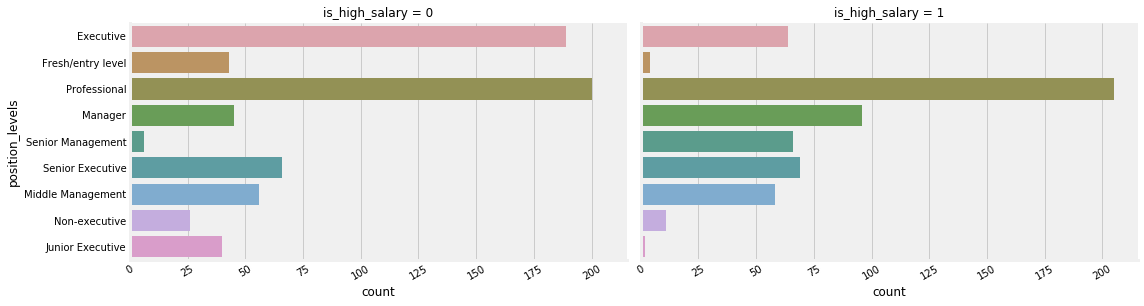

In [61]:
g = sns.catplot(y="position_levels", col="is_high_salary",
                data=jobs, saturation=.5,
                kind="count", ci=None, aspect=2, height=4, orient="h")
g.set_xticklabels(rotation=30)
plt.show()

**Most frequent words for each class**

In [62]:
stopword_list = stopwords.words('english')

# remove negation terms
stopword_list.remove('no')
stopword_list.remove('not')


In [63]:
cvt = CountVectorizer(stop_words=stopword_list, ngram_range=(1,1))
counts = cvt.fit_transform(jobs['job_description'])


In [64]:
job_desc_counts = pd.DataFrame(counts.toarray(), columns=cvt.get_feature_names())


In [65]:
job_desc_counts['is_high_salary'] = jobs['is_high_salary']


In [66]:
job_desc_counts.head()


,000,01,05,06c2859,07,10,100,1000,1000s,100gb,...,zenika,zeppelin,zero,zigbee,zilingo,zini,zinier,zone,zookeeper,is_high_salary
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0


From a simple count of the most frequent words in the job description, it seems like both classes have a very similar set of words. However, the individual words do not really convey much meaning.

In [67]:
def plot_freq_words(job_desc_counts):
    job_desc_grouped = job_desc_counts.groupby('is_high_salary').sum().T
    job_desc_low = job_desc_grouped[0.0].sort_values(ascending=False)
    job_desc_high = job_desc_grouped[1.0].sort_values(ascending=False)
    plt.figure(figsize=(16,8))
    plt.subplot(121)
    sns.barplot(x=job_desc_low.values[0:20], y=job_desc_low.index[0:20])
    plt.title("Low salary")
    plt.xlabel('frequency')
    plt.subplot(122)
    sns.barplot(x=job_desc_high.values[0:20], y=job_desc_high.index[0:20])
    plt.title("High salary")
    plt.xlabel('frequency')
    plt.show()

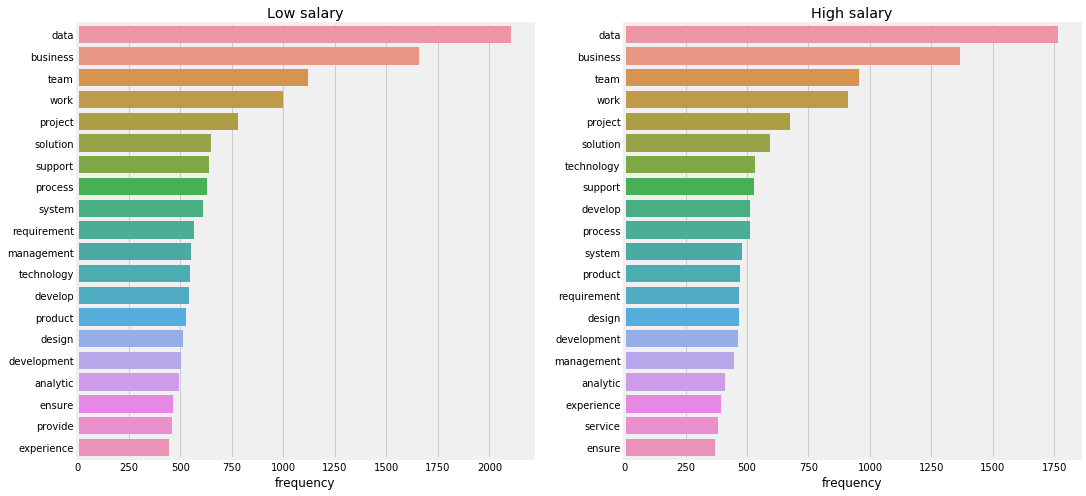

In [68]:
plot_freq_words(job_desc_counts)

The bi-gram counts show more meaningful phrases and we can see that machine learning, big data and deep learning appear frequently in job descriptions for both salary classes. In addtion, we see that the jobs also require people to work closely in teams to use data to meet business needs.

In [69]:
# get bi-grams
cvt = CountVectorizer(stop_words=stopword_list, ngram_range=(2,2))
counts = cvt.fit_transform(jobs['job_description'])

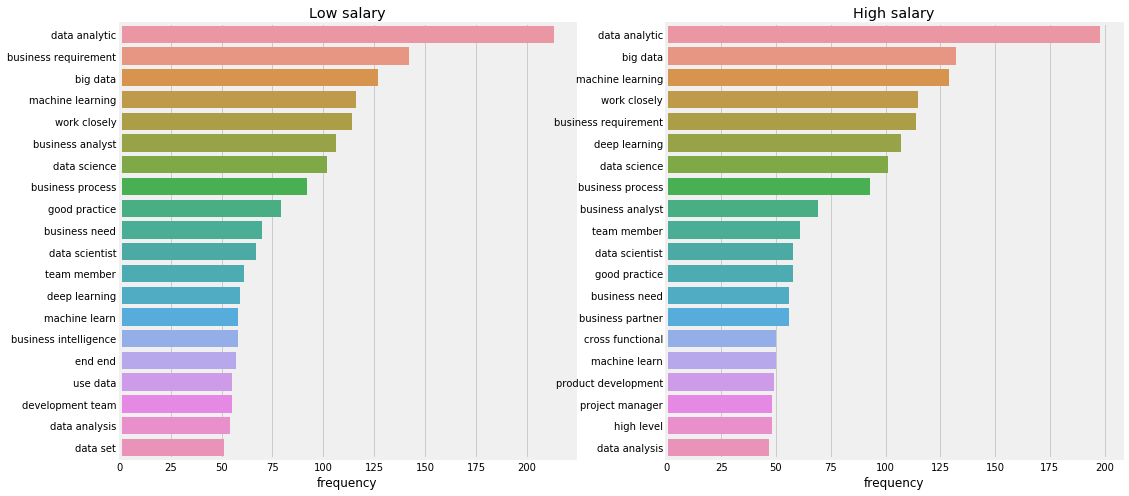

In [70]:
job_desc_counts = pd.DataFrame(counts.toarray(), columns=cvt.get_feature_names())
job_desc_counts['is_high_salary'] = jobs['is_high_salary']
plot_freq_words(job_desc_counts)

Let's take a look at the TF-IDF frequencies. Even after taking into acount the inverse document frequency, it seems like the most frequent bi-grams are similar to the ones above.

In [71]:
tfidf = TfidfVectorizer(stop_words=stopword_list, ngram_range=(2,2))
counts = tfidf.fit_transform(jobs['job_description'])

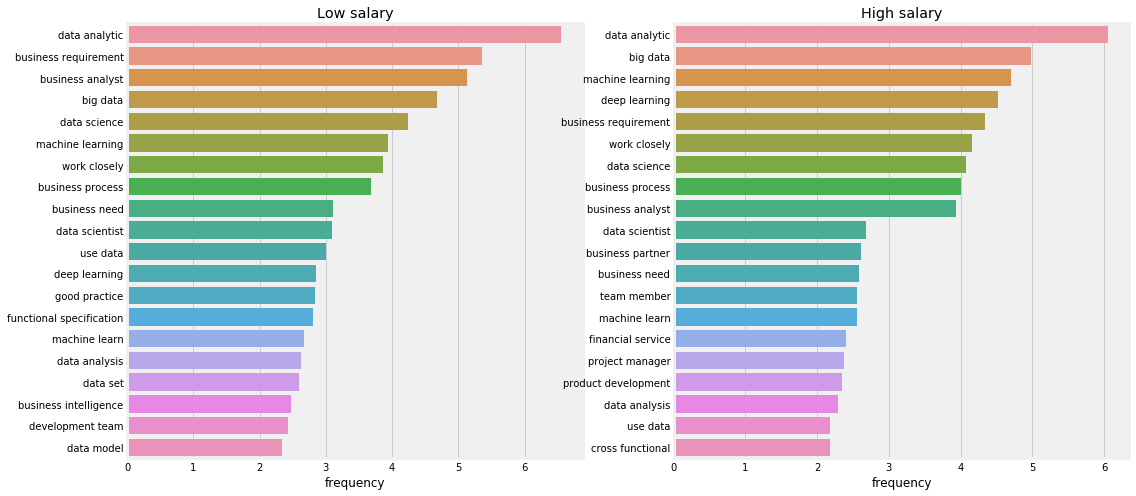

In [72]:
job_desc_counts = pd.DataFrame(counts.toarray(), columns=tfidf.get_feature_names())
job_desc_counts['is_high_salary'] = jobs['is_high_salary']
plot_freq_words(job_desc_counts)

**Create dummy variables for employment types**

In [73]:
employment_dummies = pd.get_dummies(jobs['employment_types']).drop('Contract', axis=1)
jobs = pd.concat([jobs, employment_dummies], axis=1)
jobs.drop('employment_types', axis=1, inplace=True)

**Create dummy variables for position levels**

In [74]:
position_dummies = pd.get_dummies(jobs['position_levels']).drop('Fresh/entry level', axis=1)
jobs = pd.concat([jobs, position_dummies], axis=1)
jobs.drop('position_levels', axis=1, inplace=True)

### Modelling

**Train test split**

In [75]:
X_train, X_test, y_train, y_test = train_test_split(jobs.drop('is_high_salary', axis=1), jobs['is_high_salary'], 
                                                    test_size=0.3, stratify=jobs['is_high_salary'], random_state=33)

In [76]:
predictors = ['north', 'south', 'east', 'west',
       'central', 'islandwide', 'Accounting / Auditing / Taxation',
       'Admin / Secretarial', 'Advertising / Media ',
       'Architecture / Interior Design', 'Banking and Finance',
       'Building and Construction', 'Consulting ', 'Customer Service',
       'Design', 'Education and Training', 'Engineering',
       'Environment / Health  ', 'Events / Promotions ', 'F&B',
       'General Management', 'General Work', 'Healthcare / Pharmaceutical',
       'Human Resources ', 'Information Technology', 'Insurance', 'Legal',
       'Logistics / Supply Chain', 'Manufacturing',
       'Marketing / Public Relations ', 'Others', 'Professional Services',
       'Public / Civil Service', 'Purchasing / Merchandising',
       'Real Estate / Property Management', 'Risk Management',
       'Sales / Retail ', 'Sciences / Laboratory / R&D', 'Social Services',
       'Telecommunications', 'Travel / Tourism', 'Full Time',
       'Internship', 'Permanent', 'Temporary', 'Executive', 'Junior Executive', 'Manager',
       'Middle Management', 'Non-executive', 'Professional',
       'Senior Executive', 'Senior Management', 'job_description', 'otherRequirements']

**Adding text features to the non-text predictors**

In [77]:
# Custom transformer to add vectorize text and add it to the other predictors
class XWithText(BaseEstimator, TransformerMixin):
    def __init__(self, max_features = None, ngram_range=(1,1), max_df=1.0, min_df=1, use_idf=False):
        self.stop_words = stopword_list
        self.ngram_range = ngram_range
        self.max_df = max_df
        self.min_df = min_df
        self.max_features = max_features
        self.use_idf = use_idf
        self.vectorizer = TfidfVectorizer(stop_words=stopword_list, ngram_range=self.ngram_range, max_df=self.max_df,min_df=self.min_df, 
                                          max_features=self.max_features, use_idf=self.use_idf)
        self.columns = []
    def fit(self, X, y=None):
        summary = X['job_description'] + X['otherRequirements']
        self.vectorizer.fit(summary)
        columns = X.columns.tolist()
        columns.remove('job_description')
        columns.remove('otherRequirements')
        columns.extend(self.vectorizer.get_feature_names())
        self.columns = columns # save the list of columns so that it can accessed later
        return self
    def transform(self, X):
        summary = X['job_description'] + X['otherRequirements']
        counts = self.vectorizer.transform(summary)
        X = np.hstack((X.drop(['job_description','otherRequirements'], axis=1).values, counts.toarray()))
        return X

In [78]:
# code to test my custom transformer
mytransformer = XWithText(ngram_range=(1,2))
mytransformer.fit(X_train[predictors])
transformed = mytransformer.transform(X_train[predictors])
transformed.shape

(872, 98260)

In [79]:
len(mytransformer.columns)

98260

In [80]:
def test_models(train_model, param_grid, X, y, cv=3, verbose=False):
    '''
        Function to search through models with different parameters
        
        Paramters
        ----------
        train_model: estimator object used as classifier
        param_grid: dictionary of parameter values
        X: DataFrame
            Training design matrix 
        y: Series
            Training labels
        verbose: boolean, False by default
            If True, print progress of the training
    '''
    # create combinations
    param_names, values = zip(*param_grid.items())
    combinations = itertools.product(*values)
    
    num_combinations = 1
    for v in values:
        num_combinations *= len(v)
    
    cv_results = []
    
    start = time.time()
    for index, params in enumerate(combinations):
        
        # run model
        model_params = dict(zip(param_names, params))
        scores = train_model(X, y, cv, False, **model_params)
        
        # save cv score
        cv_results.append({'params': model_params, 'cv_score': scores, 'mean_score': np.mean(scores), 
                           'std_score': np.std(scores)})
        
        if (verbose) & (index%10 == 9):
            print (f"Done {index+1} out of {num_combinations} in {np.round((time.time()-start)/60, 2)} min")
            
    return cv_results

**Logistic regression model**

I am using the custom transformer to vectorize the text data in `job_description` and `otherRequirements` and combine them with the non-text features. These features are standardized because I am using logistic regression with regularization. Then, I chose to use SelectKBest features to limit the number of features used in the training. This is for practical reasons to limit the training time and because the slight improvement in performance does not justify the much longer training time.

I also used the Area Under ROC as the scoring metric to optimize the classifier. This is because I am interested in classifiying both classes correctly and it allows me to evaluate the models independent of the threshold.

In [81]:
def train_logistic(X, y, cv, return_train, ngram_range, use_idf, kbest_k, logr_C):
    '''
        Function to train logistic regression models
        
        Parameters
        -----------
        X: DataFrame
            Training design matrix
        y: Series
            Training labels
        cv: int
            Number of cross validation folds
        return_train: boolean
            If True, return the transformers and estimator after fitting. If False, return cross validation scores.
        ngram_range: tuple
            ngram_range parameter for TdidfVectorizer in the custom transformer
        use_idf: boolean
            use_idf parameter for TdidfVectorizer in the custom transformer
        kbest_k: int
            k parameter for SelectKBest
        logr_C: float
            C parameter for LogisticRegression
    '''
    # transform X to get the text features
    text_transfomer = XWithText(ngram_range=ngram_range, use_idf=use_idf)
    text_transfomer.fit(X)
    new_X = text_transfomer.transform(X)
    # standardize data to use in logistic regression with regularization
    ss = StandardScaler()
    ss.fit(new_X)
    Xs = ss.transform(new_X)
    # select k best features
    kbest = SelectKBest(k=kbest_k)
    X_best = kbest.fit_transform(Xs, y)
    # estimator
    logr = LogisticRegression(random_state=42, solver='liblinear', C=logr_C)
    if (return_train): # return fitted transformers and estimator
        logr.fit(X_best, y)
        return {'text_transformer': text_transfomer, 'ss': ss, 'kbest': kbest, 'estimator': logr}
    
    # return cv scores
    return cross_val_score(logr, X_best, y, cv=cv, n_jobs=-1, scoring='roc_auc')


In [82]:
def best_params(model_list):
    '''
        Function that returns the best parameters for the model with best mean score
    '''
    sorted_list = sorted(model_list, key=lambda k: -k['mean_score']) 
    return sorted_list[0]

In [83]:
## run this cell to load the results without having to search through the parameters

models_result = load_file('models_result')

In [84]:
## run this cell to search through the parameters

# params_logistic = {'ngram_range': [(1,1), (1,2)], 'use_idf': [False, True], 
#              'kbest_k':[1000,2000,3000], 'logr_C':np.logspace(-4,1,5)}
# log_models_result = test_models(train_logistic, params_logistic, X_train[predictors], y_train, cv=3, verbose=True)

In [85]:
log_models_result = models_result['log_models_result']
best_params(log_models_result)


{'params': {'ngram_range': (1, 2),
  'use_idf': False,
  'kbest_k': 3000,
  'logr_C': 0.0017782794100389228},
 'cv_score': array([0.93511741, 0.95432075, 0.95302334]),
 'mean_score': 0.9474871681117522,
 'std_score': 0.008762764666027842}

**Random forest model**

I tried the random forest model because it is one of the simpler ensemble models without that many hyper parameters to tune. The advantage of the random forest is that builds many decision trees and averages the results which reduces the variance while giving better model performance over a single decision tree. Furthermore, it also gives feature importance which would be useful for determining the factors that affect salary class. I did not standardize the features because the scale of each feature can be different when using decision trees.

In [86]:
def train_rf(X, y, cv, return_train, ngram_range, use_idf, kbest_k, rf_n_estimators, rf_max_depth, rf_min_samples_split):
    '''
        Function to train random forest models
        
        Parameters
        -----------
        X: DataFrame
            Training design matrix
        y: Series
            Training labels
        cv: int
            Number of cross validation folds
        return_train: boolean
            If True, return the transformers and estimator after fitting. If False, return cross validation scores.
        ngram_range: tuple
            ngram_range parameter for TdidfVectorizer in the custom transformer
        use_idf: boolean
            use_idf parameter for TdidfVectorizer in the custom transformer
        kbest_k: int
            k parameter for SelectKBest
        rf_n_estimators: int
            n_estimators parameter for RandomForestClassifier
        rf_max_depth: int
            max_depth parameter for RandomForestClassifier
        rf_min_samples_split: int
            min_samples_split parameter for RandomForestClassifier
    '''
    text_transfomer = XWithText(ngram_range=ngram_range, use_idf=use_idf)
    text_transfomer.fit(X, y)
    new_X = text_transfomer.transform(X)
    kbest = SelectKBest(k=kbest_k)
    X_best = kbest.fit_transform(new_X, y)
    
    rf = RandomForestClassifier(random_state=42, n_estimators=rf_n_estimators, max_depth=rf_max_depth, 
                                min_samples_split=rf_min_samples_split)
    if (return_train):
        rf.fit(X_best, y)
        return {'text_transformer': text_transfomer, 'kbest': kbest, 'estimator': rf}
    return cross_val_score(rf, X_best, y, cv=cv, n_jobs=-1, scoring='roc_auc')


In [87]:
## run this cell to search through the parameters

# params_rf = {'ngram_range': [(1,1), (1,2)], 'use_idf': [False, True], 
#              'kbest_k':[2000,3000], 'rf_n_estimators':[50,70,90], 'rf_max_depth':[10,None], 
#              'rf_min_samples_split': [2,5]}
# rf_models_result = test_models(train_rf, params_rf, X_train[predictors], y_train, cv=3, verbose=1)

In [88]:
rf_models_result = models_result['rf_models_result']
best_params(rf_models_result)


{'params': {'ngram_range': (1, 2),
  'use_idf': True,
  'kbest_k': 2000,
  'rf_n_estimators': 70,
  'rf_max_depth': 10,
  'rf_min_samples_split': 5},
 'cv_score': array([0.81623728, 0.79232817, 0.85316207]),
 'mean_score': 0.8205758424113306,
 'std_score': 0.025024099661048668}

**Multinomial Naive Bayes**

I tried out the Multinomial Naive Bayes model because it works more efficiently on word frequencies and the other features are all dummy variables. In addition, the model provides the feature probabiilty given a class, which can be used to determine the factors that affect salary class.

In [89]:
def train_mnb(X, y, cv, return_train, ngram_range, use_idf, kbest_k):
    '''
        Function to train random forest models
        
        Parameters
        -----------
        X: DataFrame
            Training design matrix
        y: Series
            Training labels
        cv: int
            Number of cross validation folds
        return_train: boolean
            If True, return the transformers and estimator after fitting. If False, return cross validation scores.
        ngram_range: tuple
            ngram_range parameter for TdidfVectorizer in the custom transformer
        use_idf: boolean
            use_idf parameter for TdidfVectorizer in the custom transformer
        kbest_k: int
            k parameter for SelectKBest
    '''
    text_transfomer = XWithText(ngram_range=ngram_range, use_idf=use_idf)
    text_transfomer.fit(X)
    new_X = text_transfomer.transform(X)
    kbest = SelectKBest(k=kbest_k)
    X_best = kbest.fit_transform(new_X, y)
    mnb = MultinomialNB()
    
    if (return_train):
        mnb.fit(X_best, y)
        return {'text_transformer': text_transfomer, 'kbest': kbest, 'estimator': mnb}
    return cross_val_score(mnb, X_best, y, cv=cv, n_jobs=-1, scoring='roc_auc')
    

In [90]:
## run this cell to search through the parameters

# params_mnb = {'ngram_range': [(1,1),(1,2),(1,3)], 'use_idf': [False, True], 'kbest_k':[2000,3000]}
# mnb_models_result = test_models(train_mnb, params_mnb, X_train_ds[predictors_ds], y_train_ds, 
#                                    cv=3, verbose=1)

In [91]:
mnb_models_result = models_result['mnb_models_result']
best_params(mnb_models_result)


{'params': {'ngram_range': (1, 1), 'use_idf': True, 'kbest_k': 2000},
 'cv_score': array([0.81374378, 0.78407426, 0.92509363]),
 'mean_score': 0.8409705563535521,
 'std_score': 0.06070469069030953}

**Summary of results**

Mean AUC score:
- Logistic regression: 0.95
- Random forest: 0.82
- Multinomial Naive Bayes: 0.84

The best model is the logistic regression model. Let's try evaluating the model on the test set.

In [92]:
# train model on all the training data
model_log = train_logistic(X_train[predictors], y_train, cv=3, return_train=True, **best_params(log_models_result)['params'])


/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [18 38] are constant.
  UserWarning)
/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [93]:
# evaluate logistic model with test data
def test_best_model(model, X, y, scoring=None):
    new_X = model['text_transformer'].transform(X)
    Xs = model['ss'].transform(new_X)
    X_best = model['kbest'].transform(Xs)
    if scoring=='roc_auc':
        y_scores = model['estimator'].predict_proba(X_best)
        return roc_auc_score(y, y_scores[:,1])
    elif scoring=='classification_report':
        y_pred = model['estimator'].predict(X_best)
        return classification_report(y, y_pred)
    elif scoring=='confusion':
        y_pred = model['estimator'].predict(X_best)
        return confusion_matrix(y, y_pred)
    
    return model['estimator'].score(X_best, y)

The AUC score on the test data is 0.80 which is much lower than the score obtained from the cross validation. This means that the model does not generalize well to new data. This could be due to overfitting of the model on the training data because of many redundant features. Another reason could be the noise in the data from irrelevant job postings that were not cleaned, which could affect the training of the model. However, this is still much better than a baseline model (AUC = 0.5) of randomly guessing the salary class.

> More data collection, data cleaning and model parameter tuning could be done given more time.

In [94]:
test_score = test_best_model(model_log, X_test[predictors], y_test, scoring='roc_auc')
print ('auc:', test_score)

auc: 0.8025910907888305


In [95]:
test_score = test_best_model(model_log, X_test[predictors], y_test)
print ("accuracy:", test_score)

accuracy: 0.7352941176470589


In [96]:
test_score = test_best_model(model_log, X_test[predictors], y_test, scoring='classification_report')
print (test_score)

              precision    recall  f1-score   support

           0       0.76      0.74      0.75       201
           1       0.71      0.73      0.72       173

   micro avg       0.74      0.74      0.74       374
   macro avg       0.73      0.74      0.73       374
weighted avg       0.74      0.74      0.74       374



In [97]:
def get_coef(model):
    coef = model['estimator'].coef_.reshape(-1)
    mask = model['kbest'].get_support()
    features = np.asarray(model['text_transformer'].columns)[mask]
    return pd.DataFrame({'features': features, 'coef': coef, 'coef_abs': np.abs(coef)})

**Factors that affect salary class**

The top few factors are actually the position levels: manager and senior management have positive coefficients, which means the odds of being in the high salary class are higher as compared to fresh/entry level (reference). Executive and junior executive have negative coefficients, which means that the odds of being in the high salary class are lower as compared to fresh/entry level. The coefficients of these factors make sense as we would expect manager and senior management to get high salaries. 

For example,

$$\frac{odds(high\ salary|Manager)}{odds(high\ salary|Fresh)} = exp({\frac{Manager\ coef}{Manager\ std\ dev}}) = 1.17$$

This means that the odds of being a high paying job given that it is a Manager position is 1.17 times the odds of being a high paying job given that it is a Fresh/Entry position.

Other factors that affect salary class include words/skills like management experience, 10 years experience, experience with technology, programming ability, spark and python. 

In [98]:
log_model_coef = get_coef(model_log)
log_model_coef_sorted = log_model_coef.sort_values('coef_abs', ascending=False)
log_model_coef_sorted[0:50]

,features,coef,coef_abs
7,Executive,-0.054712,0.054712
9,Manager,0.052884,0.052884
10,Senior Management,0.052394,0.052394
11,10,0.046788,0.046788
8,Junior Executive,-0.043067,0.043067
13,10 year,0.042008,0.042008
1165,grant,0.031477,0.031477
186,apac,0.031012,0.031012
2646,task,-0.030124,0.030124
768,diploma,-0.029750,0.029750


In [99]:
X_matrix = pd.DataFrame(model_log['text_transformer'].transform(X_train[predictors]), 
             columns=model_log['text_transformer'].columns)
print ('std dev of Executive:', X_matrix['Executive'].std())
print ('std dev of Manager:', X_matrix['Manager'].std())

std dev of Executive: 0.4024497996326583
std dev of Manager: 0.3229345133010339


In [100]:
# calculate odds ratio
print ('odds of (high salary|Executive) / odds of (high salary|Fresh):', 
       np.exp(log_model_coef_sorted[0:1]['coef'].values[0] / X_matrix['Executive'].std()))
print ('odds of (high salary|Manager) / odds of (high salary|Fresh):', 
       np.exp(log_model_coef_sorted[1:2]['coef'].values[0] / X_matrix['Manager'].std()))

odds of (high salary|Executive) / odds of (high salary|Fresh): 0.8728894823302495
odds of (high salary|Manager) / odds of (high salary|Fresh): 1.1779308736540335


<h2> Question 2 - Factors that distinguish job category </h2>

<h3> EDA </h3>

**Distribution of job titles**

From the distribution, we can see that the most common job titles in the dataset are Business Analyst, Data Scientist and Data Engineer. The number of job titles falls off quickly because there are many variants of the same job title such that each job title string becomes unique.

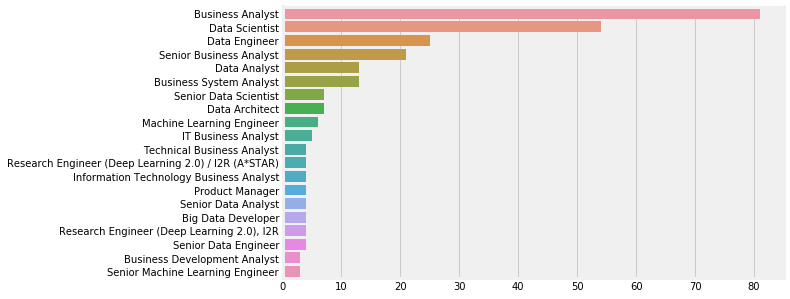

In [101]:
plt.figure(figsize=(8,5))
job_title_counts = jobs['job_title'].value_counts()
sns.barplot(x=job_title_counts.values[0:20], y=job_title_counts.index[0:20])
plt.show()

Let's find out what differentiates a Data Scientist from other jobs.

In [102]:
jobs['is_data_scientist'] = [1 if 'data scientist' in value.lower() else 0 for value in jobs['job_title']]

**Distribution of monthly salary**

The data scientist and non data scientist salary distributions look quite similar. Salary might not be so good at differentiating the two classes.

/Users/joshuamei/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


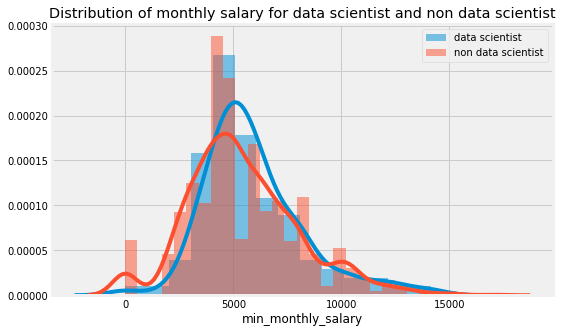

In [103]:
plt.figure(figsize=(8,5))
sns.distplot(jobs[jobs['is_data_scientist'] == 1]['min_monthly_salary'], hist_kws={"alpha":0.5}, label='data scientist')
sns.distplot(jobs[jobs['is_data_scientist'] == 0]['min_monthly_salary'], hist_kws={"alpha":0.5}, label='non data scientist')
plt.legend()
plt.title('Distribution of monthly salary for data scientist and non data scientist')
plt.show()

### Modeling

> There is an imbalance in the data scientist class (8%) vs non data scientist class. We need to handle the class imbalance when training the model.

In [104]:
jobs['is_data_scientist'].mean()

0.08025682182985554

In [105]:
X_train_ds, X_test_ds, y_train_ds, y_test_ds = train_test_split(jobs.drop('is_data_scientist', axis=1), jobs['is_data_scientist'], 
                                                    test_size=0.3, stratify=jobs['is_data_scientist'], random_state=44)

In [106]:
predictors_ds = ['max_monthly_salary', 'min_monthly_salary', 'is_high_salary',
       'Accounting / Auditing / Taxation',
       'Admin / Secretarial', 'Advertising / Media ',
       'Architecture / Interior Design', 'Banking and Finance',
       'Building and Construction', 'Consulting ', 'Customer Service',
       'Design', 'Education and Training', 'Engineering',
       'Environment / Health  ', 'Events / Promotions ', 'F&B',
       'General Management', 'General Work', 'Healthcare / Pharmaceutical',
       'Human Resources ', 'Information Technology', 'Insurance', 'Legal',
       'Logistics / Supply Chain', 'Manufacturing',
       'Marketing / Public Relations ', 'Others', 'Professional Services',
       'Public / Civil Service', 'Purchasing / Merchandising',
       'Real Estate / Property Management', 'Risk Management',
       'Sales / Retail ', 'Sciences / Laboratory / R&D', 'Social Services',
       'Telecommunications', 'Travel / Tourism', 'Full Time',
       'Internship', 'Permanent', 'Temporary', 'Executive', 'Junior Executive',
       'Manager', 'Middle Management', 'Non-executive', 'Professional',
       'Senior Executive', 'Senior Management', 'job_description', 'otherRequirements']

Due to the class imbalance, I performed upsampling of the training portion with SMOTE within each fold of the cross validation. I also used the f1-score as the scoring metric to optimize the classifier. This is because I am more interested in classifying the Data Scientist job correctly (while keep false positives low) rather than the accuracy (which could easily achieve 92% simply by classifying all jobs as non data scientist).

In [107]:
def cv_with_smote(X, y, estimator, cv=3, random_state=None):
    '''
        Function to perform smote in cross validation
    '''
    skf = StratifiedKFold(n_splits=cv, random_state=random_state)

    f1_score_list = []
    for train_index, test_index in skf.split(X, y):
        X_train = X[train_index]
        y_train = y.iloc[train_index]
        X_test = X[test_index]
        y_test = y.iloc[test_index]
        sm = SVMSMOTE(random_state=random_state) # perform upsampling with smote in each fold
        X_train_oversampled, y_train_oversampled = sm.fit_sample(X_train, y_train)
        estimator.fit(X_train_oversampled, y_train_oversampled)  
        y_pred = estimator.predict(X_test)

        f1_score_list.append(f1_score(y_test, y_pred))
        
    return f1_score_list

**Logistic Regression**

Again, I started out with using logistic regression as a simple first model. I used the same the custom transformer to vectorize the text data in `job_description` and `otherRequirements` and combine them with the non-text features. These features are standardized because I am using logistic regression with regularization. Then, I chose to use SelectKBest features to limit the number of features used in the training.

In [108]:
def train_logistic_ds(X, y, cv, return_train, ngram_range, use_idf, kbest_k, logr_C):
    '''
        Function to train logistic regression models
        
        Parameters
        -----------
        X: DataFrame
            Training design matrix
        y: Series
            Training labels
        cv: int
            Number of cross validation folds
        return_train: boolean
            If True, return the transformers and estimator after fitting. If False, return cross validation scores.
        ngram_range: tuple
            ngram_range parameter for TdidfVectorizer in the custom transformer
        use_idf: boolean
            use_idf parameter for TdidfVectorizer in the custom transformer
        kbest_k: int
            k parameter for SelectKBest
        logr_C: float
            C parameter for LogisticRegression
    '''
    text_transfomer = XWithText(ngram_range=ngram_range, use_idf=use_idf)
    text_transfomer.fit(X)
    new_X = text_transfomer.transform(X)
    ss = StandardScaler()
    ss.fit(new_X)
    Xs = ss.transform(new_X)
    kbest = SelectKBest(k=kbest_k)
    X_best = kbest.fit_transform(Xs, y)
    logr = LogisticRegression(random_state=42, solver='liblinear', C=logr_C)
    if (return_train):
        logr.fit(X_best, y)
        return {'text_transformer': text_transfomer, 'ss': ss, 'kbest': kbest, 'estimator': logr}
    
    return cv_with_smote(X_best, y, logr, cv=cv, random_state=42)

In [109]:
## run this cell to search through the parameters

# params_logistic_ds = {'ngram_range': [(1,1), (1,2)], 'use_idf': [False, True], 
#              'kbest_k':[2000,3000], 'logr_C':np.logspace(-4,1,5)}
# log_models_result_ds = test_models(train_logistic_ds, params_logistic_ds, X_train_ds[predictors_ds], y_train_ds, 
#                                    cv=3, verbose=1)


In [110]:
log_models_result_ds = models_result['log_models_result_ds']
best_params(log_models_result_ds)

{'params': {'ngram_range': (1, 2),
  'use_idf': True,
  'kbest_k': 3000,
  'logr_C': 10.0},
 'cv_score': [0.8148148148148148, 0.851063829787234, 0.9387755102040816],
 'mean_score': 0.8682180516020436,
 'std_score': 0.05204013832226948}

**AdaBoost model**

I wanted to try a simple boosting model to see how it performed against the logistic regression model. I chose the AdaBoost model with a decision tree classifier as the base estimator.

In [111]:
def train_adaboost(X, y, cv, return_train, ngram_range, use_idf, kbest_k, dtc_max_depth, dtc_min_samples_split,
                  ada_n_estimators, ada_learning_rate):
    '''
        Function to train AdaBoost models
        
        Parameters
        -----------
        X: DataFrame
            Training design matrix
        y: Series
            Training labels
        cv: int
            Number of cross validation folds
        return_train: boolean
            If True, return the transformers and estimator after fitting. If False, return cross validation scores.
        ngram_range: tuple
            ngram_range parameter for TdidfVectorizer in the custom transformer
        use_idf: boolean
            use_idf parameter for TdidfVectorizer in the custom transformer
        kbest_k: int
            k parameter for SelectKBest
        dtc_max_depth: int
            max_depth parameter for DecisionTreeClassifier
        dtc_min_samples_split: int
            min_samples_split parameter for DecisionTreeClassifier
        ada_n_estimators: int
            n_estimators parameter for AdaBoostClassifier
        ada_learning_rate: float
            learning_rate parameter for AdaBoostClassifier
    '''
    text_transfomer = XWithText(ngram_range=ngram_range, use_idf=use_idf)
    text_transfomer.fit(X)
    new_X = text_transfomer.transform(X)
    kbest = SelectKBest(k=kbest_k)
    X_best = kbest.fit_transform(new_X, y)
    dtc = DecisionTreeClassifier(random_state=42, max_depth=dtc_max_depth, min_samples_split=dtc_min_samples_split)
    ada = AdaBoostClassifier(base_estimator=dtc, random_state=42, n_estimators=ada_n_estimators, 
                             learning_rate=ada_learning_rate)
    if (return_train):
        ada.fit(X_best, y)
        return {'text_transformer': text_transfomer, 'kbest': kbest, 'estimator': ada}
    
    return cv_with_smote(X_best, y, ada, cv=cv, random_state=44)

In [112]:
## run this cell to search through the parameters

# params_adaboost = {'ngram_range': [(1,2)], 'use_idf': [False], 
#              'kbest_k':[3000], 'dtc_max_depth':[1], 'dtc_min_samples_split':[2], 
#                    'ada_n_estimators': np.arange(95,150,5), 'ada_learning_rate': np.arange(0.9,1.0,1.1)}
# adaboost_models_result = test_models(train_adaboost, params_adaboost, X_train_ds[predictors_ds], y_train_ds, 
#                                    cv=3, verbose=1)

In [113]:
adaboost_models_result = models_result['adaboost_models_result']

best_params(adaboost_models_result) 

{'params': {'ngram_range': (1, 2),
  'use_idf': False,
  'kbest_k': 3000,
  'dtc_max_depth': 1,
  'dtc_min_samples_split': 2,
  'ada_n_estimators': 110,
  'ada_learning_rate': 0.9},
 'cv_score': [0.5, 0.55, 0.5555555555555555],
 'mean_score': 0.5351851851851852,
 'std_score': 0.024982847339318583}

**SVM**

Lastly, I also tried using SVM with a linear kernel (so that I can get the weights assigned to the features).

In [114]:
def train_svm(X, y, cv, return_train, ngram_range, use_idf, kbest_k, svm_C):
    '''
        Function to train AdaBoost models
        
        Parameters
        -----------
        X: DataFrame
            Training design matrix
        y: Series
            Training labels
        cv: int
            Number of cross validation folds
        return_train: boolean
            If True, return the transformers and estimator after fitting. If False, return cross validation scores.
        ngram_range: tuple
            ngram_range parameter for TdidfVectorizer in the custom transformer
        use_idf: boolean
            use_idf parameter for TdidfVectorizer in the custom transformer
        kbest_k: int
            k parameter for SelectKBest
        svm_C: float
            C parameter for LinearSVC
    '''
    text_transfomer = XWithText(ngram_range=ngram_range, use_idf=use_idf)
    text_transfomer.fit(X)
    new_X = text_transfomer.transform(X)
    ss = StandardScaler()
    ss.fit(new_X)
    Xs = ss.transform(new_X)
    kbest = SelectKBest(k=kbest_k)
    X_best = kbest.fit_transform(Xs, y)
    svm = LinearSVC(C=svm_C, random_state=42)
    
    if (return_train):
        svm.fit(X_best, y)
        return {'text_transformer': text_transfomer, 'ss': ss, 'kbest': kbest, 'estimator': svm}
    
    return cv_with_smote(X_best, y, svm, cv=cv, random_state=42)

In [115]:
## run this cell to search through the parameters

# params_svm = {'ngram_range': [(1,1), (1,2)], 'use_idf': [False, True], 
#              'kbest_k':[2000,3000], 'svm_C':np.logspace(-3,2,5)}
# svm_models_result = test_models(train_svm, params_svm, X_train_ds[predictors_ds], y_train_ds, 
#                                    cv=3, verbose=1)

In [116]:
svm_models_result = models_result['svm_models_result']
best_params(svm_models_result)

{'params': {'ngram_range': (1, 2),
  'use_idf': True,
  'kbest_k': 3000,
  'svm_C': 0.001},
 'cv_score': [0.8148148148148148, 0.8333333333333333, 0.9387755102040816],
 'mean_score': 0.8623078861174097,
 'std_score': 0.05459674613091625}

In [117]:
# save all the model results so that they can loaded later without re-running the grid search
models_result = {
    'log_models_result': log_models_result,
    'rf_models_result': rf_models_result,
    'mnb_models_result': mnb_models_result,
    'log_models_result_ds': log_models_result_ds,
    'adaboost_models_result': adaboost_models_result,
    'svm_models_result': svm_models_result
}

save_file(models_result, 'models_result')

**Summary of results**

Mean f1-score:
- Logistic regression: 0.87
- AdaBoost: 0.54
- SVM: 0.86

In this case, the logistic regression and SVM have about the same performance. Let's try evaluating both models on the test set.

In [118]:
# train logistic regression model
model_log_ds = train_logistic_ds(X_train_ds[predictors_ds], y_train_ds, cv=3, return_train=True, **best_params(log_models_result_ds)['params'])


/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [ 6 35] are constant.
  UserWarning)
/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [119]:
test_score_log = test_best_model(model_log_ds, X_test_ds[predictors_ds], y_test_ds, scoring='classification_report')
print ('Test score for logistic regression')
print (test_score_log)

Test score for logistic regression
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       344
           1       0.46      0.57      0.51        30

   micro avg       0.91      0.91      0.91       374
   macro avg       0.71      0.75      0.73       374
weighted avg       0.92      0.91      0.92       374



In [120]:
# train SVM
model_svm = train_svm(X_train_ds[predictors_ds], y_train_ds, cv=3, return_train=True, **best_params(svm_models_result)['params'])


/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [ 6 35] are constant.
  UserWarning)
/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [121]:
test_score_svm = test_best_model(model_svm, X_test_ds[predictors_ds], y_test_ds, scoring='classification_report')
print ('Test score for SVM')
print (test_score_svm)

Test score for SVM
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       344
           1       0.46      0.57      0.51        30

   micro avg       0.91      0.91      0.91       374
   macro avg       0.71      0.75      0.73       374
weighted avg       0.92      0.91      0.92       374



The f1-score on the test data for both models are very similar. The f1-score were 0.53 and 0.52 for logistic regression and SVM respectively. This is somewhat better than the baseline f1-score of 0.15 if we had predicted all jobs as data scientist. However, the score is again much lower than the score obtained from the cross validation. This means that the model does not generalize well to new data. This could be due to reasons discussed in the previous question. 

Possible ways to improve the performance of the model could be to do more data cleaning, tune the classification threshold and possibly more feature engineering.

**Factors that distinguish the data scientist job**

Looking at the 50 features below (from the logistic regression model), we can observe that all of the words/phrases have position coefficients except the word 'data'. This makes sense because we are looking at all the data related jobs, hence almost all the jobs will have the term 'data' in the description / requirements. Hence, having the word 'data' lowers the chance that it is actually a data scientist job. 

The top words/phrases that are most important actually describe the job requirements that are largely specific to data scientists. For example, 'explainability' appears as the top word that increases the chance of the job being a data scientist. This is because data scientists usually have to explain the results / interpret the parameters of the model to other stakeholders. That is why explainability of the models is an important factor for data scientists. 


They also have to collaborate with the product, application development and engineering teams to address the business problems. Other phrases such as monitoring model performance, machine learning model development, randomised controlled trial, feature building and statistical testing all fall within the job scope of a data scientist. Hence, they are strong indicators of a data scientist job. In addition, words such as NLTK, SQL, scipy, numpy, pandas, svm also appear as top factors because these are the tools and skills that a data scientist requires.

In [122]:
log_model_ds_coef = get_coef(model_log_ds)
log_model_ds_coef.sort_values('coef_abs', ascending=False)[0:50]

,features,coef,coef_abs
2185,query optimization,0.250669,0.250669
1352,invaluable,0.226343,0.226343
2158,python application,0.216082,0.216082
852,etc collaborate,0.207893,0.207893
2436,seq2seq,0.206212,0.206212
595,data superior,0.198106,0.198106
1688,model product,0.193865,0.193865
1780,nltk,0.190253,0.190253
2250,related library,0.188569,0.188569
942,explainability,0.178328,0.178328


## Executive summary

This is a report on the analysis on current data-related jobs to secure more contracts for the firm. It explores 2 main questions: the factors that categorize a job as low or high paying and the factors that distinguish a data scientist from other data-related jobs. These will help the firm to manage client expectations on expected salary and the requirements for a data scientist job.

The approach taken for this study is as follows:
1. Data collection through scraping [mycareersfuture.sg](https://www.mycareersfuture.sg/) website
2. Cleaning the collected data
3. Exploratory data analysis
4. Exploring and validating different models
5. Evaluating the model on the test data
6. Interpret the results to address the business problem

### Data collection

The job postings were collected from mycareersfuture.sg. I used the mycareersfuture.sg APIs to retrieve the list of job postings for different search terms (eg. data scientist, business analyst) and the job details for individual postings.

### Data cleaning

The data collected requires quite extensive cleaning because there are many irrelevant job postings and duplicate postings that turn up in the search. Removing the irrelevant/duplicate job postings was a largely manual and iterative process. As I did data exploration and discovered irrelevant postings, I would add it to a list to be removed. The cleaning process was not exhaustive and more work could be done to further clean the data. Missing values were filled in appropriately and features such as company location (region in Singapore), employment type (eg. permanent), postition level (eg. manager), industry type were also processed to be used as predictors of salary class and job title later.

### Factors that categorize data-related jobs as low / high paying

#### Exploratory data analysis

The maximum monthly salary has a very wide range with a few extreme monthly salary amounts (>\\$40000) as compared to the rest of the data. Therefore, the minimum monthly salary was chosen as a conservative estimate to categorize a job as low or high paying. The median minimum monthly salary (\\$5000) was taken as the threshold to categorize the jobs. The median is an appropriate threshold as it divides the jobs into 2 approximately equal salary classes. Those above \$5000 are considered high salary jobs.

Data analysis also shows that position level and employment type might be good indicators of salary level. However, initial analysis of the most frequent words in the job description and requirements does not show many differences in the words used between low and high salary jobs. They were many generic terms used to describe data-related jobs such as data analytic, machine learning and business requirement.

####  Modeling results

Besides features such as position level, the job description and requirements were split into single words and bi-grams (which are pairs of words) and their frequencies were counted for each job. These frequencies were used as predictors for salary class.

The best classifier produced an Area Under ROC score of 0.80 (1 is best, equivalent to perfect classifier; 0.5 is worst, equivalent to random guess) on the test data which is an improvment from the baseline (random guess) of 0.5. However, it should be noted that the test score (obtained by performing predictions on the test data) is lower than the training score of 0.95 (obtained by performing predictions on the training data). This means that the classifier was not able to generalize too well to new data. There are several possible reasons:

1. The classifier is over-fitted on the training data because too many redundant features were used.
2. The dataset is not well cleaned enough and still contains irrelevant jobs that contributes as noise in the training and test data.
3. The classifier performance is limited by the limited training data. Some words and bi-grams that appear in the test data might not have appeared in the training data. Hence, it would improve the classifier accuracy if there was more data to train on.

Overall, one of the most important factors for classifying a job as low or high paying is the position level. The analysis clearly shows that senior management and manager jobs are more likely to be classified as high paying as compared to executive and junior executive jobs. This is in line with the initial analysis during data exploration. 

Other important factors that are extracted from the job description/requirements include experience in management and technology, working in/leading teams, programming and analytical ability, familiarity with web technology, spark and python. Having these words/skills in the job description/requirements would increase the likelihood of the job being high paying. Conversely, terms such as SPSS, science, math, fresh graduate, diploma and being in the public service would decrease the likelihood of it being a high paying job. It is slightly surprsing to see science and math as lowering the chance of a high paying data-related job.

Therefore, given the position level and job requirements, the firm would be able to advise the client on whether the job is paying at the correct level. The firm is also able to advise the client on the requirements/skills that would likely enable the client to get a high paying data-related job. 

### Factors that distinguish data scientist from other data-related jobs

#### Exploratory data analysis

Initial analysis shows that the distributions of monthly salaries for data scientist vs other jobs are quite similar. Hence, it suggests that salaries would not be a good indicator of data scientist jobs.

The proportion of data scientist jobs in the dataset is about 8\% which means that there is a class imbalance. This imbalance in the data was handled appropriately using sampling techniques while training the classifier. Salary, industry type, employment type, position level, job description and requirements were used as predictors. 

#### Modeling results

The best classifier produced a f1-score of 0.53 on the test data and 0.87 on the training data (1 is the best and 0 is the worst). The f1-score is a measurement that takes into account the recall (proportion of data scientist jobs classified correctly) and precision (proportion of actual data scientist jobs among those classified as data scientist). This measurement was used to optimize the classifier to classify data scientist jobs correctly and not optimize for accuracy (because it would be easy to achieve 92\% accuracy simply by classifying all jobs as non-data scientist). The relatively poor f1-score on the test data could be due to the same reasons discussed in the previous analysis. To improve the performance, it would be best to collect more data scientist job postings to give the classifier more samples to train on.

The key factors that distinguish a data scientist from other jobs come from the job description and requirements instead of position level etc. The key words / phrases that are most important actually describe the job requirements that are largely specific to data scientists (which makes sense). For example, 'explainability' appears as the top word that increases the chance of the job being a data scientist. This is because data scientists usually have to explain the results / interpret the parameters of the model to other stakeholders. That is why explainability of the models is an important factor for data scientists. They also have to collaborate with the product, application development and engineering teams to address the business problems. Other phrases such as monitoring model performance, machine learning model development, randomised controlled trial, feature building and statistical testing all fall within the job scope of a data scientist. Hence, they are strong indicators of a data scientist job. In addition, words such as NLTK, SQL, scipy, numpy, pandas, svm also appear as top factors because these are the tools and skills that a data scientist requires.

With this insights, the firm can advise the client on the requirements/skills of a data scientist job and recommend the client on the suitability of the data scientist role. 

### Difficulties and limitations
1. Cleaning of the data was non-exhaustive due to limited time.

2. Training the models require extensive amount of time and computing resources. Given the limited time and resources, tuning of the model parameters was also restricted to practical limits.

### Further work
1. More pre-processing of the text such as removing stop words specific to the context of job postings
2. More feature engineering such as using a binary count for the text tokens instead of the frequency
